In [1]:
import os
import sys
import base64
import folium
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
from deep_translator import GoogleTranslator
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import  classification_report, accuracy_score, confusion_matrix, brier_score_loss
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import Javascript, display, HTML, Image
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ROCAUC


#mlflow.set_tracking_uri("sqlite:///mlflow.db")
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None

In [2]:
dir_path = "../data/01_raw/"
all_files = os.listdir(dir_path)
csv_files = [file for file in all_files if file.endswith('.csv')]
data = {}

for file in csv_files:
    f_path = dir_path + file
    f_name = file.split('.')[0]
    data[f_name] = pd.read_csv(f_path)

In [3]:
customers = data['olist_customers_dataset']
geolation = data['olist_geolocation_dataset']
order_item = data['olist_order_items_dataset']
order_payments = data['olist_order_payments_dataset']
order_reviews = data['olist_order_reviews_dataset']
orders = data['olist_orders_dataset']
products = data['olist_products_dataset']
selllers = data['olist_sellers_dataset']
product_category = data['product_category_name_translation']

In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
geolation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [6]:
order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [8]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [9]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [10]:
selllers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [11]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [12]:
product_category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [13]:
def mermaid(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

In [14]:
mermaid("""
graph TD;
    A(Join Tables) --> B(Remove unique keys);
    B--> C(Check Data);
    C--> D(EDA);
    D--> E(Custom pipeline);
    E ---> E1(Translate columns into english trarget_columns = 'product_category_name', 'reviews_title', 'reviews'); 
    E1--> F(Data Split);
    F--> G(Train model);
    G----> G1(Top3 models)
    G1---> I
    G--> H(Explainable AI)
    H--> I(Model Tuining);
    I--> J(Model Caliberation);
    J--> K(Testing Model);
    K--> L(Create viz Dashbord);
    
""")

In [15]:
data_list = [customers, geolation, order_item, order_payments, order_reviews, orders, products, selllers, product_category]

In [16]:
for i in data_list:
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  

### Joining Datasets

In [17]:
df_1 = (
    orders
      .merge(order_item, on='order_id')
      .merge(order_payments, on='order_id')
      .merge(customers, on='customer_id')
)

In [18]:
df_1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117596,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,1,credit_card,3,195.00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
117597,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,1,credit_card,5,271.01,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
117598,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,1,credit_card,4,441.16,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
117599,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,1,credit_card,4,441.16,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [19]:
df = (
    df_1
     .merge(selllers, on='seller_id')
     .merge(orders, on='order_id')
     .merge(products, on='product_id')
     .merge(order_reviews, on='order_id')
)

In [20]:
df

,order_id,customer_id_x,order_status_x,order_purchase_timestamp_x,order_approved_at_x,order_delivered_carrier_date_x,order_delivered_customer_date_x,order_estimated_delivery_date_x,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,customer_id_y,order_status_y,order_purchase_timestamp_y,order_approved_at_y,order_delivered_carrier_date_y,order_delivered_customer_date_y,order_estimated_delivery_date_y,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,

In [21]:
df['order_item_id'].unique()

array([ 1,  2,  3,  4,  5,  6, 11,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

In [22]:
df['product_category_name'].unique()

array(['utilidades_domesticas', 'bebes', 'cool_stuff', 'esporte_lazer',
       'brinquedos', 'moveis_decoracao', 'perfumaria', 'beleza_saude',
       'pet_shop', 'musica', 'automotivo', 'relogios_presentes', 'audio',
       'informatica_acessorios', 'eletronicos', 'alimentos', 'telefonia',
       'consoles_games', 'papelaria', 'cama_mesa_banho',
       'sinalizacao_e_seguranca', 'artigos_de_festas', nan,
       'fashion_roupa_masculina', 'fashion_roupa_feminina',
       'construcao_ferramentas_ferramentas',
       'fashion_bolsas_e_acessorios', 'ferramentas_jardim',
       'moveis_escritorio', 'industria_comercio_e_negocios', 'pcs',
       'moveis_sala', 'construcao_ferramentas_construcao', 'market_place',
       'casa_conforto', 'casa_construcao',
       'construcao_ferramentas_iluminacao', 'artes',
       'construcao_ferramentas_jardim', 'eletroportateis', 'cine_foto',
       'moveis_quarto', 'telefonia_fixa', 'instrumentos_musicais',
       'climatizacao', 'malas_acessorios', 'fashi

## EDA

In [23]:
def convert_to_datetime(df, feature):
    match feature:
        case 'order_delivered_customer_date_x' | 'order_delivered_customer_date_y' | 'order_estimated_delivery_date_x'| 'order_estimated_delivery_date_y' | 'order_approved_at_x' | 'order_approved_at_y':
            df[feature] = pd.to_datetime(df[feature])
            return df

In [24]:
convert_to_datetime(df, 'order_delivered_customer_date_x')
convert_to_datetime(df, 'order_delivered_customer_date_y')
convert_to_datetime(df, 'order_estimated_delivery_date_x')
convert_to_datetime(df, 'order_estimated_delivery_date_y')

,order_id,customer_id_x,order_status_x,order_purchase_timestamp_x,order_approved_at_x,order_delivered_carrier_date_x,order_delivered_customer_date_x,order_estimated_delivery_date_x,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,customer_id_y,order_status_y,order_purchase_timestamp_y,order_approved_at_y,order_delivered_carrier_date_y,order_delivered_customer_date_y,order_estimated_delivery_date_y,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350,maua,SP,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-

### Creating new column for late orders

In [25]:
df['late_orders_x'] = (df['order_delivered_customer_date_x'] - df['order_estimated_delivery_date_x']).dt.days

In [26]:
df['late_orders_y'] = (df['order_delivered_customer_date_y'] - df['order_estimated_delivery_date_y']).dt.days

In [39]:
def value_count_norm(df, feature):
    value_count_norm = df[feature].value_counts()
    value_count_norm1 = df[feature].value_counts(normalize=True) * 100
    value_count_norm1_concat = pd.concat([value_count_norm, value_count_norm1], axis=1)
    value_count_norm1_concat.columns = ['Count', 'Frequncy']
    return value_count_norm1_concat

In [40]:
def create_donut_plot(df, feature):
    match feature:
        case 'order_status_x' | 'order_status_y' | 'payment_type':
            n = len(value_count_norm(df, feature).index)
            colors = sns.color_palette('pastel')[0:n]
            plt.pie(value_count_norm(df, feature).iloc[:, 1],
                    colors = colors, autopct='%1.2f%%',
                    pctdistance=0.85,
                    labels=value_count_norm(df, feature).index)
            my_circle=plt.Circle( (0,0), 0.7, color='white')
            p=plt.gcf()
            p.gca().add_artist(my_circle)
            plt.title('{}'.format(feature))
            return plt.show()
        case 'payment_installments' | 'payment_sequential':
            single_payment = [x for x in df[feature] if x == 1]
            installment_payment = [x for x in df[feature] if x > 1]
            
            single_payment_count = len(single_payment)
            installment_payment_count = len(installment_payment)
            
            labels = ['Single Pyament', 'Installments']
            sizes = [single_payment_count, installment_payment_count]
            colors = sns.color_palette('pastel')[0:2]
            plt.pie(sizes, labels=labels,
                    pctdistance=0.85, autopct='%1.1f%%',
                    colors=colors)
            my_circle=plt.Circle( (0,0), 0.7, color='white')
            p=plt.gcf()
            p.gca().add_artist(my_circle)
            return plt.show()
        case 'late_orders_x' | 'late_orders_y':
            early_deliveries = [x for x in df[feature] if x <= 0]
            late_deliveries = [x for x in df[feature] if x > 0]
            
            labels = ['early_deliveries', 'late_deleveries']
            sizes = [len(early_deliveries), len(late_deliveries)]
            
            colors = sns.color_palette('pastel')[0:2]
            plt.pie(sizes, labels=labels,
                    pctdistance=0.85, autopct='%1.1f%%',
                    colors=colors)
            my_circle=plt.Circle( (0,0), 0.7, color='white')
            p=plt.gcf()
            p.gca().add_artist(my_circle)
            return plt.show()
            
        
        case _:
            print("Error")
            

In [41]:
def create_bar_chart(df, feature):
    match feature:
        case 'customer_state' | 'seller_state':
            figure(figsize=(20, 8))
            df.groupby([feature])['price'].sum().sort_values(ascending=True).plot(kind='barh')
            return plt.show()
        
        case _:
            print("Error")

In [42]:
def impact_of_late_orders(df, feature):
    match feature:
        case 'late_orders_x':
            late_deliveries = [x for x in df[feature] if x > 0]
            late_deliveries_df = df[df[feature] > 0]
            
            fig = px.histogram(x=late_deliveries_df['review_score'])
            return fig.show()
        
        case _:
            print("error")

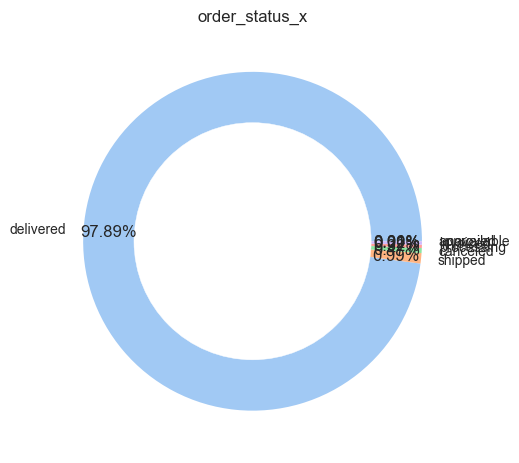

In [43]:
create_donut_plot(df, 'order_status_x')

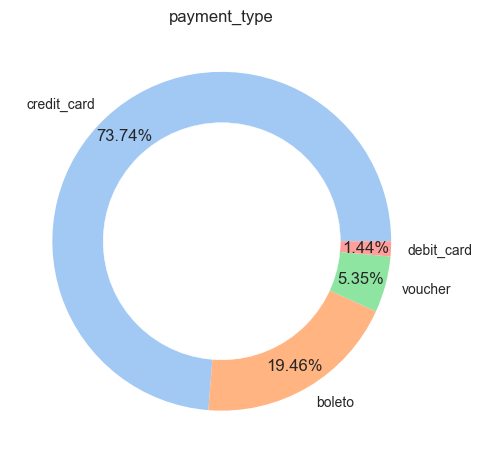

In [46]:
create_donut_plot(df, 'payment_type')

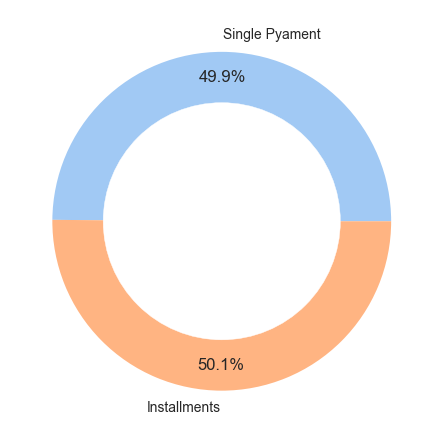

In [47]:
create_donut_plot(df, 'payment_installments')

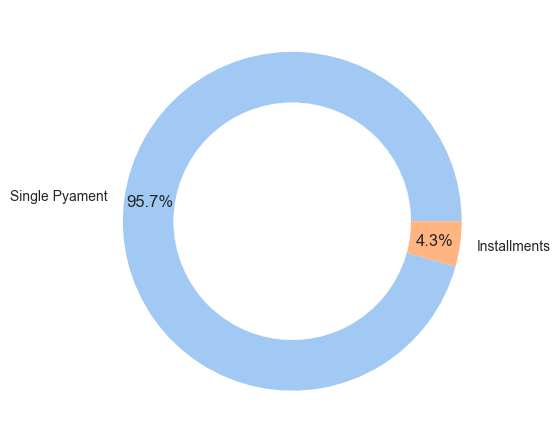

In [49]:
create_donut_plot(df, 'payment_sequential')

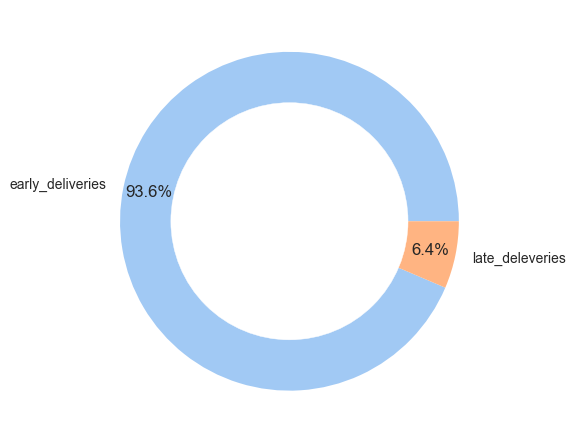

In [50]:
create_donut_plot(df, 'late_orders_x')

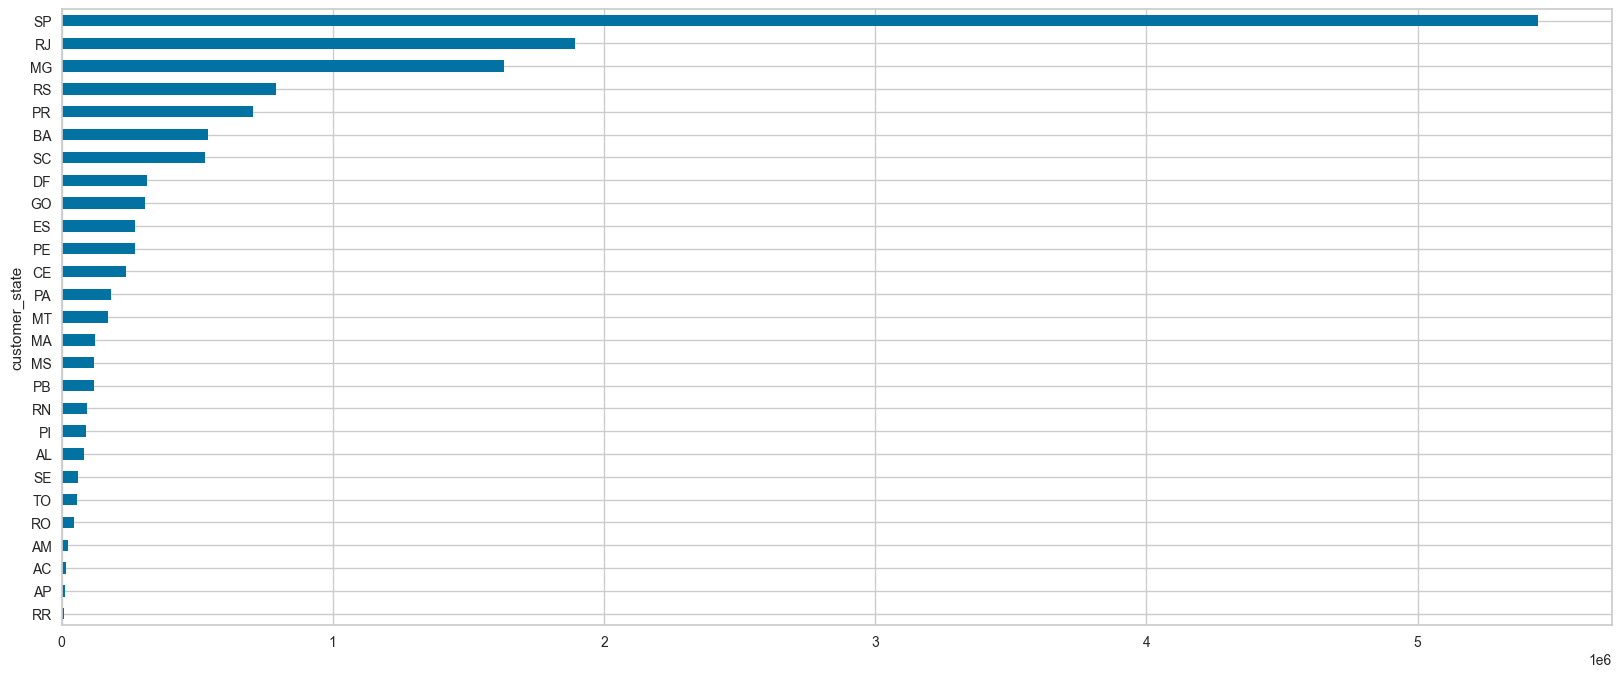

In [51]:
create_bar_chart(df, 'customer_state')

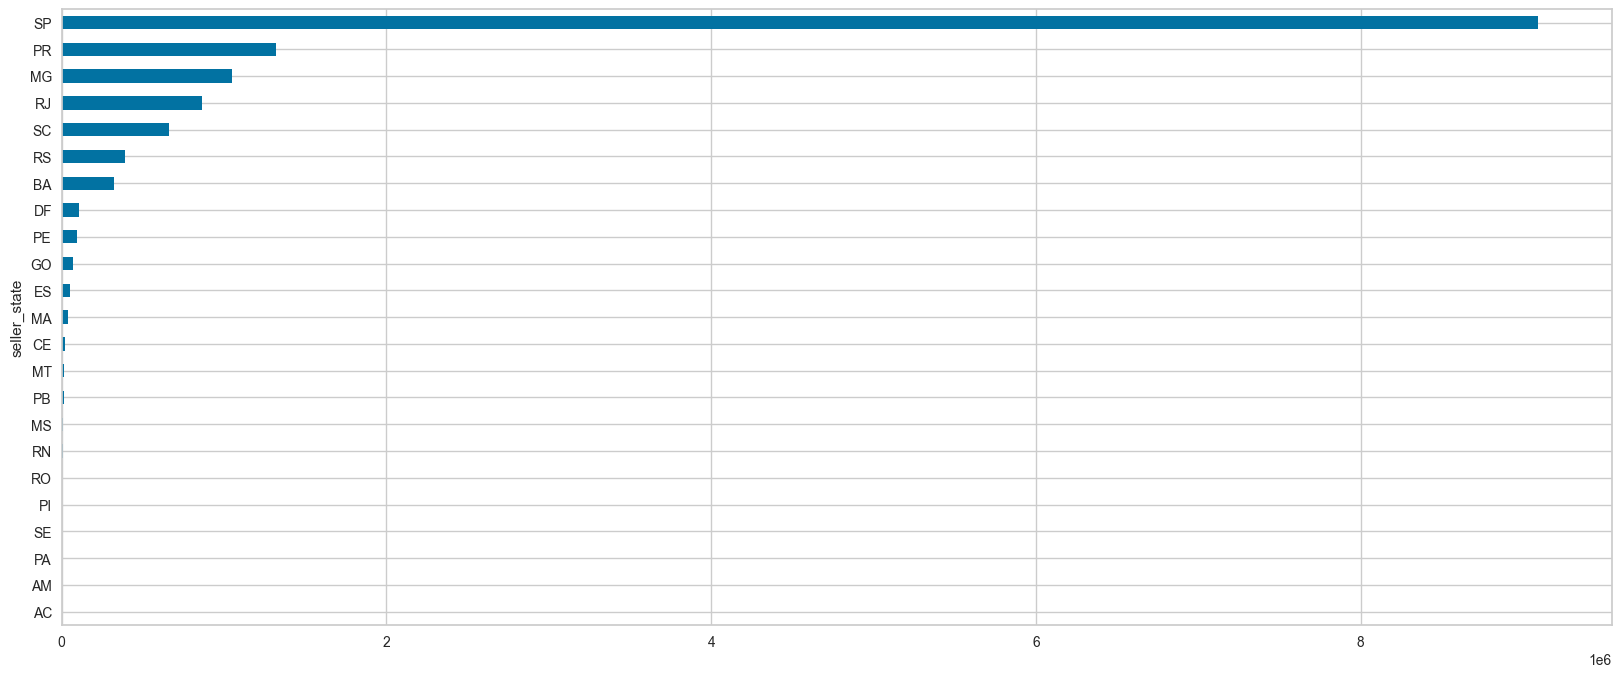

In [52]:
create_bar_chart(df, 'seller_state')

In [53]:
impact_of_late_orders(df, 'late_orders_x')

In [54]:
px.histogram(x=df['review_score'])